In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('../data/creditcard.csv')

# Check for missing values
if df.isnull().values.any():
    df = df.dropna()  # Drop rows with any missing values if any

# Drop irrelevant feature
df.drop('Time', axis=1, inplace=True)

# Scale the 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [4]:
# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Filter the data to have only normal transactions for training
normal_data = df[df['Class'] == 0]
fraud_data = df[df['Class'] == 1]
normal_unlabeled = normal_data.drop('Class', axis=1)
fraud_unlabeled = fraud_data.drop('Class', axis=1)
#normalize data
#X_mean = X.mean()
#X_std = X.std()
#normal_data = (normal_unlabeled - X_mean)/X_std
#fraud_data = (fraud_unlabeled - X_mean)/X_std
#
#normal_data = normal_data.assign(Class=0)
#fraud_data = fraud_data.assign(Class=1)
#
#normal_data.head()

In [5]:
# Split the normal data into training and test sets
X_train, X_test_normal, _, y_test_normal = train_test_split(
    normal_data.drop('Class', axis=1), normal_data['Class'], test_size=0.2, random_state=42)

# Include all fraud transactions and a portion of normal transactions in the test set
X_test = pd.concat([X_test_normal, fraud_data.drop('Class', axis=1)])
y_test = pd.concat([y_test_normal, fraud_data['Class']])

In [6]:
# Normalize the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Define datasets
train_data = TensorDataset(X_train_tensor, X_train_tensor)
test_data = TensorDataset(X_test_tensor, X_test_tensor)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
# Define the AutoEncoder model
class VariationalAE(nn.Module):
    def __init__(self):
        super(VariationalAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 14),
            nn.LeakyReLU(),
            nn.Linear(14, 7),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 7),
            nn.LeakyReLU(),
            nn.Linear(7, 14),
            nn.LeakyReLU(),
            nn.Linear(14, X.shape[1]),
            nn.Sigmoid()
        )
        self.mean_layer = nn.Linear(7, 2)
        self.logvar_layer = nn.Linear(7, 2)
        
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).cpu()
        z = mean + var*epsilon
        #z = torch.sigmoid(z)
        #print(z)
        return z
    
    def decode(self, x):
        return self.decoder(x)
     
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    
    
# Initialize the model, loss function, and optimizer
model = VariationalAE()
criterion = nn.MSELoss()
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train_model(model, dataloader):
    model.train()
    total_loss = 0
    for data, target in dataloader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(data)
        loss = loss_function(data, x_hat, mean, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [9]:
epoch_losses = []
epochs = 50
for epoch in range(epochs):
    loss = train_model(model, train_loader)
    epoch_losses.append(loss)
    print(f'Epoch {epoch+1}, Loss: {loss}')

Epoch 1, Loss: 1.0331347686315628
Epoch 2, Loss: 1.0000378607227753
Epoch 3, Loss: 0.9999982048000052
Epoch 4, Loss: 1.0000325216082087
Epoch 5, Loss: 0.9999968222581944
Epoch 6, Loss: 0.9999966875439825
Epoch 7, Loss: 1.0000018719195918
Epoch 8, Loss: 0.9999958393308106
Epoch 9, Loss: 0.9999986046492282
Epoch 10, Loss: 0.999997978842386
Epoch 11, Loss: 0.9999930005673618
Epoch 12, Loss: 1.000001153615699
Epoch 13, Loss: 0.9999991683860676
Epoch 14, Loss: 0.9999938094647801
Epoch 15, Loss: 0.9999969927787982
Epoch 16, Loss: 1.000014911618002
Epoch 17, Loss: 1.0000030584444675
Epoch 18, Loss: 0.9999936477029062
Epoch 19, Loss: 0.9999937747862477
Epoch 20, Loss: 0.9999984843498143
Epoch 21, Loss: 0.9999976907937997
Epoch 22, Loss: 0.9999991394474591
Epoch 23, Loss: 0.9999953248633987
Epoch 24, Loss: 0.9999976552515535
Epoch 25, Loss: 0.999999258434531
Epoch 26, Loss: 1.000005048390983
Epoch 27, Loss: 0.9999954135533995
Epoch 28, Loss: 1.0000436895170035
Epoch 29, Loss: 1.0000032463735185

In [15]:
def evaluate_model(model, dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, _ in dataloader:
            x_hat, mean, logvar = model(data)
            loss = loss_function(data, x_hat, mean, logvar)
            losses.extend(loss.item() for _ in range(data.size(0)))
    return losses

In [16]:
train_loss = evaluate_model(model, train_loader)
average_train_loss = np.mean(train_loss)
print(f'Average Training Reconstruction Loss: {average_train_loss}')

# Evaluate model to get losses for each instance in the test set
test_losses = evaluate_model(model, test_loader)
average_test_loss = np.mean(test_losses)
print(f'Average Test Reconstruction Loss: {average_test_loss}')

# Determine the threshold for anomaly detection (setting at the 95th percentile of test losses)
threshold = np.quantile(test_losses, 0.95)
print(f'Anomaly Detection Threshold: {threshold}')

Average Training Reconstruction Loss: 1.0000000610731938
Average Test Reconstruction Loss: 1.2170860417645122
Anomaly Detection Threshold: 1.7696905136108398


Accuracy: 0.9586958416877343, 
Precision: 0.17173837005946135, 
Recall: 0.9979674796747967, 
F1 Score: 0.29304685168606387


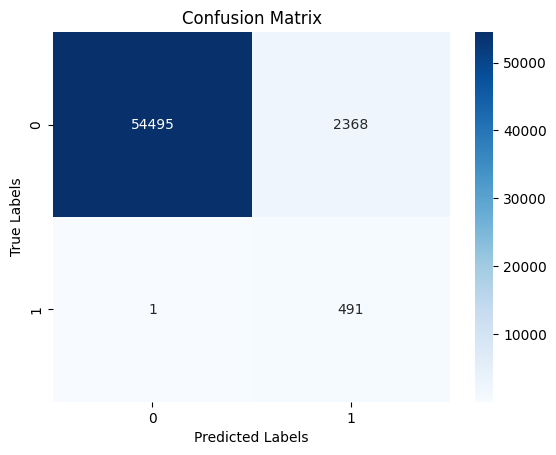

In [17]:
# Generate binary predictions based on the threshold
predicted_anomalies = np.array([1 if loss > threshold else 0 for loss in test_losses])
actual_anomalies = y_test.to_numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(actual_anomalies, predicted_anomalies)
precision = precision_score(actual_anomalies, predicted_anomalies)
recall = recall_score(actual_anomalies, predicted_anomalies)
f1 = f1_score(actual_anomalies, predicted_anomalies)

print(f'Accuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}, \nF1 Score: {f1}')

# Plotting the confusion matrix
conf_matrix = confusion_matrix(actual_anomalies, predicted_anomalies)
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()